# <center> **CSE480 Machine Vision**
## <center> Milestone 2
### <center> Team V22
### <center> **19P6038 Ali Ahmed Ali Ahmed**

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import os
import random
from skimage import exposure
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Function for loading dataset

In [2]:
def load_data(directory):
    X, y = [], []
    for label in os.listdir(directory):
        for file in os.listdir(os.path.join(directory, label)):
            image_path = os.path.join(directory, label, file)
            image = Image.open(image_path).resize((28, 28))  # Resize images to 28x28
            X.append(np.array(image))
            y.append(label)
    return np.array(X), np.array(y)

### Loading Dataset

In [3]:
dataset_directory = 'D:\ASU\Senior 2\CSE480 Machine Vision\Project\Milestone 2\Faces'
X, y = load_data(dataset_directory)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### Splitting Dataset

In [4]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### Function for Normalizing using Z method

In [5]:
def normalize_data(X):
    mean = np.mean(X, axis=(0, 1, 2))
    std = np.std(X, axis=(0, 1, 2))
    X = (X - mean) / std
    return X

### Nomralizing dataset

In [6]:
# Normalize the data using mean and standard deviation
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

### Functions for Eigenfaces visualization

In [7]:
def get_eigenfaces(images, n_components=10):
    # Flatten the images
    flattened_images = images.reshape((images.shape[0], -1))
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(flattened_images)
    
    # Eigenfaces are the principal components
    eigenfaces = pca.components_.reshape((n_components, 28, 28))
    return eigenfaces


In [8]:
def plot_eigenfaces(eigenfaces):
    plt.figure(figsize=(10, 5))
    for i, eigenface in enumerate(eigenfaces):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(eigenface, cmap='gray')
        plt.axis('off')
    plt.show()

In [9]:
def get_eigenfaces_cnn(images, n_components=10):
    # Flatten the images
    flattened_images = images.reshape((images.shape[0], -1))
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(flattened_images)
    
    # Eigenfaces are the principal components
    eigenfaces = pca.components_.reshape((n_components, 28, 28, 3))
    return eigenfaces

In [10]:
def plot_eigenfaces_cnn(eigenfaces, n_components=10):
    plt.figure(figsize=(10, 5))
    for i in range(n_components):
        ax = plt.subplot(2, 5, i + 1)
        eigenface_equalized = exposure.equalize_adapthist(eigenfaces[i])
        plt.imshow(eigenface_equalized, cmap='gray')  
        plt.axis('off')
    plt.show()

In [11]:
def get_eigenfaces_cnn_gray(images, n_components=10):
    # Flatten the images
    flattened_images = images.reshape((images.shape[0], -1))
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(flattened_images)
    
    # Eigenfaces are the principal components, convert to grayscale
    eigenfaces = pca.components_.reshape((n_components, 28, 28, 3))
    eigenfaces_gray = np.mean(eigenfaces, axis=3)  # Convert to grayscale
    return eigenfaces_gray

In [12]:
def plot_eigenfaces_cnn_gray(eigenfaces, n_components=10):
    plt.figure(figsize=(10, 5))
    for i in range(n_components):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(eigenfaces[i], cmap='gray')  
        plt.axis('off')
    plt.show()

# **Encoder-Decoder Multilayer Perceptron Network**

### MLP Model

In [13]:
# Encoder
encoder_input = Input(shape=(28, 28, 3))
x = Flatten()(encoder_input)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
encoded = Dense(128, activation='relu')(x)

# Decoder
x = Dense(256, activation='relu')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(784, activation='sigmoid')(x)
# For the classification output
classification_output = Dense(len(np.unique(y_train)), activation='softmax', name='classification_output')(encoded)

# For the decoded output
decoded_output = Reshape((28, 28, 1), name='decoded_output')(x)  # Adjust shape if RGB or grayscale



In [14]:
# Model
model_mlp = Model(inputs=encoder_input, outputs=[classification_output, decoded_output])

model_mlp.compile(optimizer='adam', 
                  loss={'classification_output': 'sparse_categorical_crossentropy', 
                        'decoded_output': 'mean_squared_error'}, 
                  metrics={'classification_output': 'accuracy'})


In [15]:
# Train the model
history_mlp = model_mlp.fit(X_train, 
                            {'classification_output': y_train, 'decoded_output': X_train}, 
                            epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50


52/52 [==============================] - 9s 85ms/step - loss: 4.2375 - classification_output_loss: 3.0894 - decoded_output_loss: 1.1481 - classification_output_accuracy: 0.1556 - val_loss: 5.0125 - val_classification_output_loss: 3.8861 - val_decoded_output_loss: 1.1264 - val_classification_output_accuracy: 0.1683
Epoch 2/50
52/52 [==============================] - 4s 75ms/step - loss: 3.2934 - classification_output_loss: 2.3858 - decoded_output_loss: 0.9076 - classification_output_accuracy: 0.3148 - val_loss: 3.8356 - val_classification_output_loss: 2.9970 - val_decoded_output_loss: 0.8385 - val_classification_output_accuracy: 0.2195
Epoch 3/50
52/52 [==============================] - 4s 72ms/step - loss: 2.8635 - classification_output_loss: 2.0215 - decoded_output_loss: 0.8420 - classification_output_accuracy: 0.3929 - val_loss: 3.2572 - val_classification_output_loss: 2.4433 - val_decoded_output_loss: 0.8139 - val_classification_output_accuracy: 0.3195
Epoch 4/50
52/52 [============

In [16]:
# Evaluate the model
loss, classification_loss, decoding_loss, classification_accuracy = model_mlp.evaluate(X_test, [y_test, X_test])

17/17 [==============================] - 1s 14ms/step - loss: 2.9520 - classification_output_loss: 2.2313 - decoded_output_loss: 0.7208 - classification_output_accuracy: 0.6257


### Loss vs Accuracy

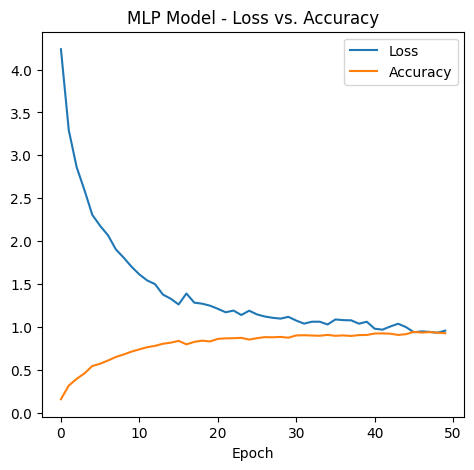

In [17]:
# Loss vs Accuracy for MLP Model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Loss')
plt.plot(history_mlp.history['classification_output_accuracy'], label='Accuracy')
plt.title('MLP Model - Loss vs. Accuracy')
plt.xlabel('Epoch')
plt.legend()

### Confusion Matrix

In [18]:
# Predictions for classification
classification_predictions, _ = model_mlp.predict(X_test)
y_pred_classes = np.argmax(classification_predictions, axis=1)

17/17 [==============================] - 1s 10ms/step


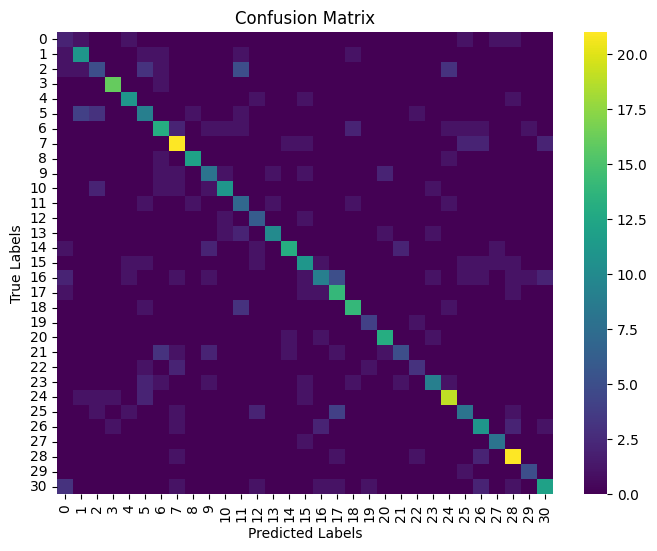

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Selecting Random Image from testing data

In [20]:
# Select a random sample from the testing data (common for both models)
random_index = random.randint(0, len(X_test) - 1)
random_test_image = X_test[random_index]
random_test_label = y_test[random_index]
actual_label_name = label_encoder.inverse_transform([random_test_label])[0]

### Prediction and Visualization for MLP Model

1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


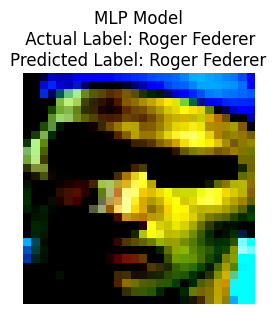

In [21]:
# Predictions for MLP Model
classification_predictions, _ = model_mlp.predict(np.array([random_test_image]))
predicted_label_mlp = np.argmax(classification_predictions)
predicted_label_name_mlp = label_encoder.inverse_transform([predicted_label_mlp])[0]

# Visualization for MLP Model
plt.figure(figsize=(6, 3))
plt.imshow(random_test_image)
plt.title(f'MLP Model\n Actual Label: {actual_label_name}\nPredicted Label: {predicted_label_name_mlp}')
plt.axis('off')
plt.show()

## **Eigen Faces of MLP Model**

17/17 [==============================] - 0s 11ms/step


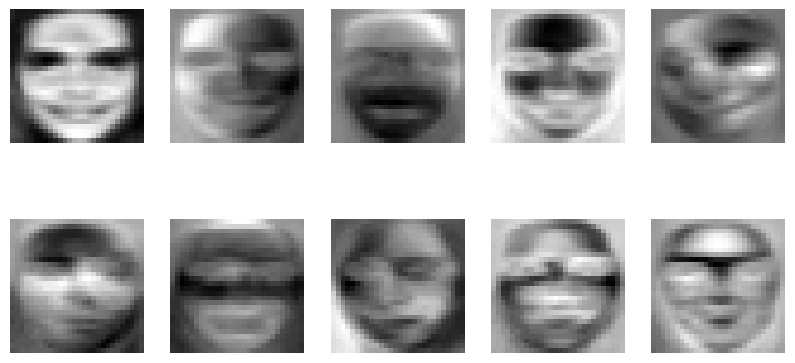

In [22]:
# Generate decoded images from the test set
_, decoded_images = model_mlp.predict(X_test)
eigenfaces_mlp = get_eigenfaces(decoded_images)
plot_eigenfaces(eigenfaces_mlp)

# **CNN - Based on Encoder Decoder**

### CNN Model

In [23]:
# Second Model: CNN-based Encoder-Decoder
tf.keras.backend.clear_session()  # Clearing previous session for the new model

# Define the encoder part of the CNN
encoder_input = Input(shape=(28, 28, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
flattened = Flatten()(x)

# Decoder branch
x = Dense(3 * 3 * 128, activation='relu')(flattened)
x = Reshape((3, 3, 128))(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='valid', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

# Final layer to reconstruct the original image
decoded_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded_output')(x)
# Classifier branch
classifier_output = Dense(len(np.unique(y_train)), activation='softmax', name='classifier_output')(flattened)


In [24]:
# Build the CNN model with two outputs
model_cnn = Model(inputs=encoder_input, outputs=[classifier_output, decoded_output])
# Compile the CNN model
model_cnn.compile(optimizer='adam', 
                  loss={'classifier_output': 'sparse_categorical_crossentropy', 
                        'decoded_output': 'mean_squared_error'},
                  metrics={'classifier_output': 'accuracy'})

In [25]:
# Train the CNN model
history_cnn = model_cnn.fit(X_train, 
                            {'classifier_output': y_train, 'decoded_output': X_train},
                            epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50
52/52 [==============================] - 12s 172ms/step - loss: 4.1135 - classifier_output_loss: 3.1232 - decoded_output_loss: 0.9903 - classifier_output_accuracy: 0.1196 - val_loss: 3.6858 - val_classifier_output_loss: 2.8462 - val_decoded_output_loss: 0.8397 - val_classifier_output_accuracy: 0.1585
Epoch 2/50
52/52 [==============================] - 7s 138ms/step - loss: 3.1493 - classifier_output_loss: 2.3677 - decoded_output_loss: 0.7816 - classifier_output_accuracy: 0.3398 - val_loss: 3.1121 - val_classifier_output_loss: 2.3828 - val_decoded_output_loss: 0.7294 - val_classifier_output_accuracy: 0.3341
Epoch 3/50
52/52 [==============================] - 7s 137ms/step - loss: 2.5448 - classifier_output_loss: 1.8180 - decoded_output_loss: 0.7268 - classifier_output_accuracy: 0.4820 - val_loss: 2.7229 - val_classifier_output_loss: 2.0184 - val_decoded_output_loss: 0.7045 - val_classifier_output_accuracy: 0.4098
Epoch 4/50
52/52 [==============================] - 7s 138ms/st

In [26]:
# Evaluate the CNN-based model
losses = model_cnn.evaluate(X_test, {'classifier_output': y_test, 'decoded_output': X_test})

17/17 [==============================] - 1s 39ms/step - loss: 2.9185 - classifier_output_loss: 2.2691 - decoded_output_loss: 0.6494 - classifier_output_accuracy: 0.6530


### Loss vs Accuracy

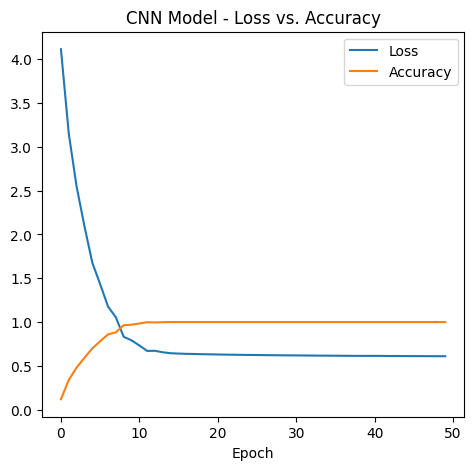

In [27]:
# Loss vs Accuracy for CNN Model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Loss')
plt.plot(history_cnn.history['classifier_output_accuracy'], label='Accuracy')
plt.title('CNN Model - Loss vs. Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Confusion Matrix

17/17 [==============================] - 1s 44ms/step


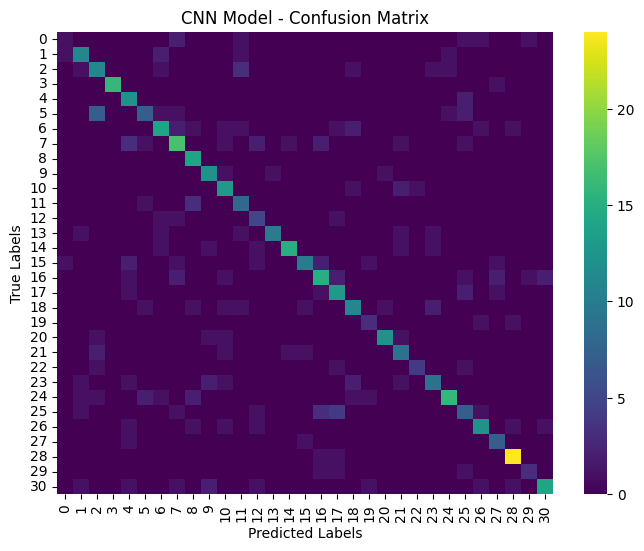

In [28]:
# Generate classification predictions for the CNN model
classification_predictions_cnn, _ = model_cnn.predict(X_test)
y_pred_classes_cnn = np.argmax(classification_predictions_cnn, axis=1)

# Confusion Matrix for CNN Model
conf_matrix_cnn = confusion_matrix(y_test, y_pred_classes_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=False, fmt='d', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Model - Confusion Matrix')
plt.show()


### Prediction and Visualization for CNN Model

1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


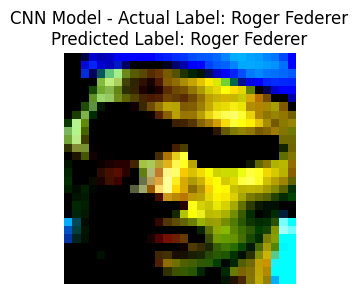

In [29]:
# Predictions for CNN Model for a single image
classification_predictions_single, _ = model_cnn.predict(np.array([random_test_image]))
predicted_label_cnn = np.argmax(classification_predictions_single, axis=1)[0]  # Extract the single label
predicted_label_name_cnn = label_encoder.inverse_transform([predicted_label_cnn])[0]

# Visualization for CNN Model
plt.figure(figsize=(6, 3))
plt.imshow(random_test_image)
plt.title(f'CNN Model - Actual Label: {actual_label_name}\nPredicted Label: {predicted_label_name_cnn}')
plt.axis('off')
plt.show()

## **Eigen Faces for CNN Model**

17/17 [==============================] - 1s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


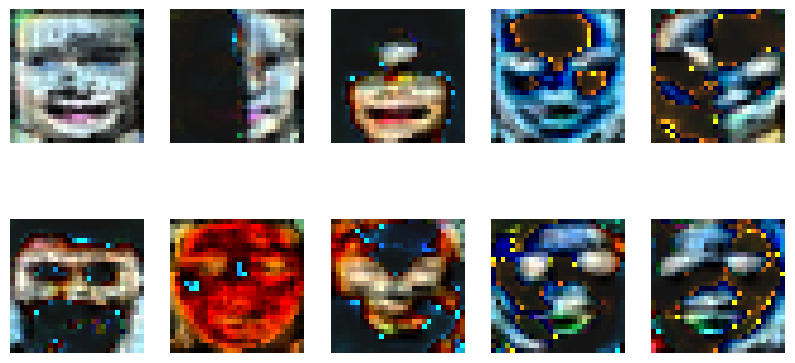

In [30]:
decoded_images_cnn = model_cnn.predict(X_test)[1]  
eigenfaces_cnn = get_eigenfaces_cnn(decoded_images_cnn)
plot_eigenfaces_cnn(eigenfaces_cnn)

17/17 [==============================] - 1s 39ms/step


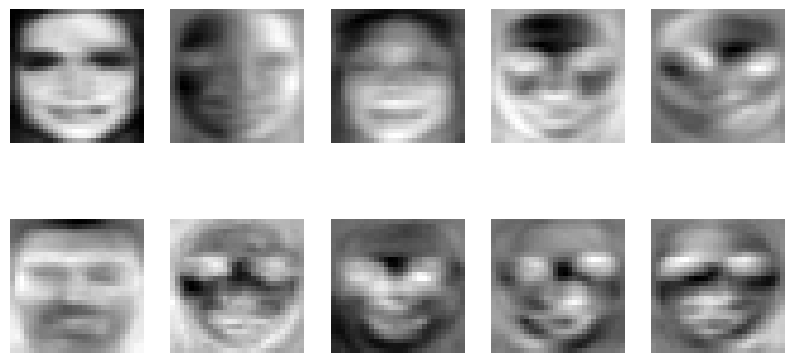

In [31]:
decoded_images_cnn = model_cnn.predict(X_test)[1]  
eigenfaces_cnn = get_eigenfaces_cnn_gray(decoded_images_cnn)
plot_eigenfaces_cnn_gray(eigenfaces_cnn)